In [7]:
from brian2 import *
from SPN import NeuronModel
from simulation import Simulation
from synapse import SynapseModel, connect

In [8]:
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

In [13]:
def main():
    # Define parameters for NeuronModel
    N = 1000
    params = {
        'v': -80 * mV,
        'u': 0 * mV / ms,
        'a': 0.2 / ms,
        'b': 0.025 / ms,
        'c': -60 * mV,
        'C': 80 * pF,
        'd': 0 * mV / ms,
        'k': 1,
        'vr': -64.4 * mV,
        'vt': -50 * mV,
        'vpeak': 25 * mV,
        'I': 0 * pA,
        'Dop1': 0.5,
        'Dop2': 0.5,
        'KAPA': 0.0289,
        'ALPHA': 0.032
    }

    # Check the times when v reaches c
    neuron_model = NeuronModel(N, params)

    # Create Simulation instance
    sim = Simulation(neuron_model)
    
    # Initial run of the simulation
    Initialize_time = 1000 * ms
    sim.run(duration = Initialize_time)

    # Initial run of the simulation
    v_reset = -66 * mV
    c_val = neuron_model.neurons.c[0]
    times = sim.dv_monitor.t
    membrane_potential = sim.dv_monitor.v[0]
    matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

    if len(matching_indices) > 0:
            earliest_time_stabilized = times[matching_indices[0]] * 1000
    else:
        earliest_time_stabilized = None

    print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

    # Create new monitors for the second phase
    sim.dv_monitor_new = StateMonitor(neuron_model.neurons, 'v', record=True)
    sim.spike_monitor_new = SpikeMonitor(neuron_model.neurons)
    sim.rate_monitor_new = PopulationRateMonitor(neuron_model.neurons)

    sim.network.add(sim.dv_monitor_new, sim.spike_monitor_new, sim.rate_monitor_new)

    # Run the second phase of the simulation
    if earliest_time_stabilized is not None:
        wait_time_after_stabilization = 1000 * ms
        sim.network.run(wait_time_after_stabilization)
        neuron_model.neurons.I = 1 * nA
        time_after_increase = 1000 * ms
        sim.network.run(time_after_increase)

        neuron_model.neurons.I = 0 * pA
        time_after_decrease = 1000 * ms
        sim.network.run(time_after_decrease)

        simulation_time = 3000 * ms
        remaining_time = simulation_time - earliest_time_stabilized - wait_time_after_stabilization - time_after_increase - time_after_decrease
        sim.network.run(remaining_time)
    else:
        print("v does not reach v_reset, stopping simulation")

    sim.plot_results(earliest_time_stabilized=earliest_time_stabilized)


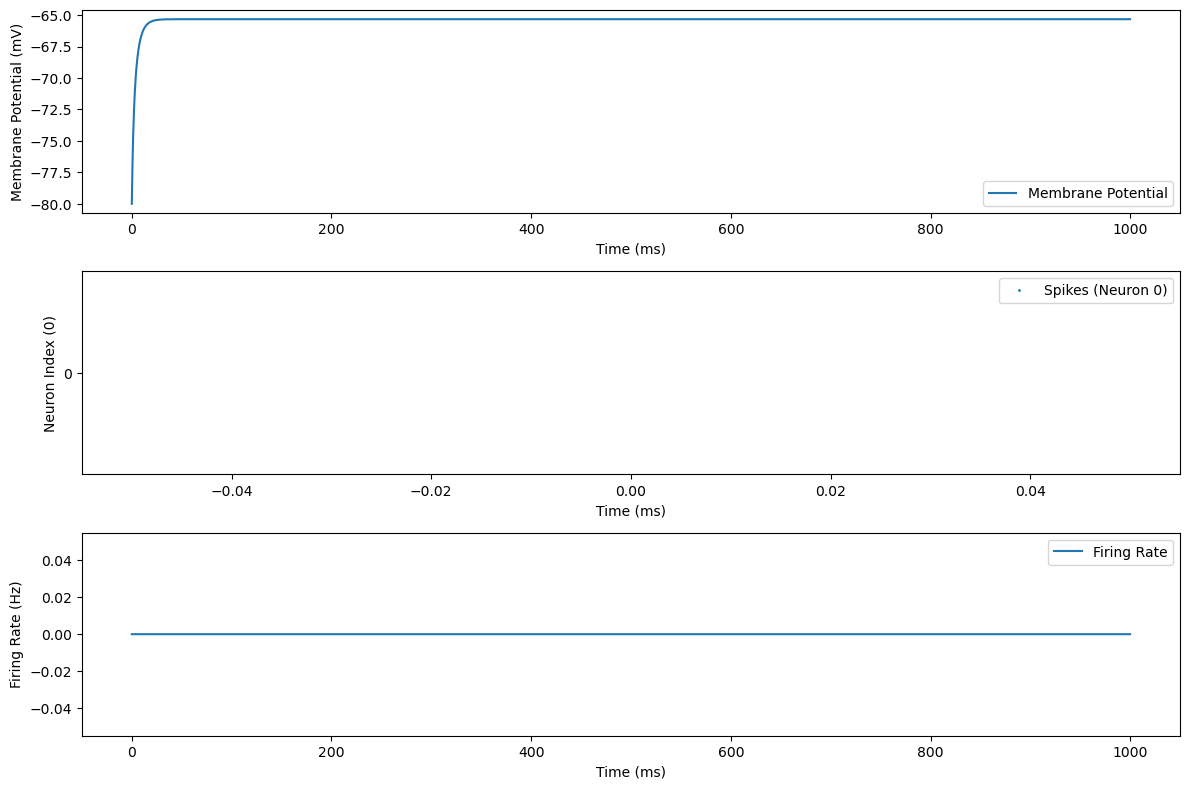

Earliest time when v stabilizes at v_reset (in ms): 12.9 s


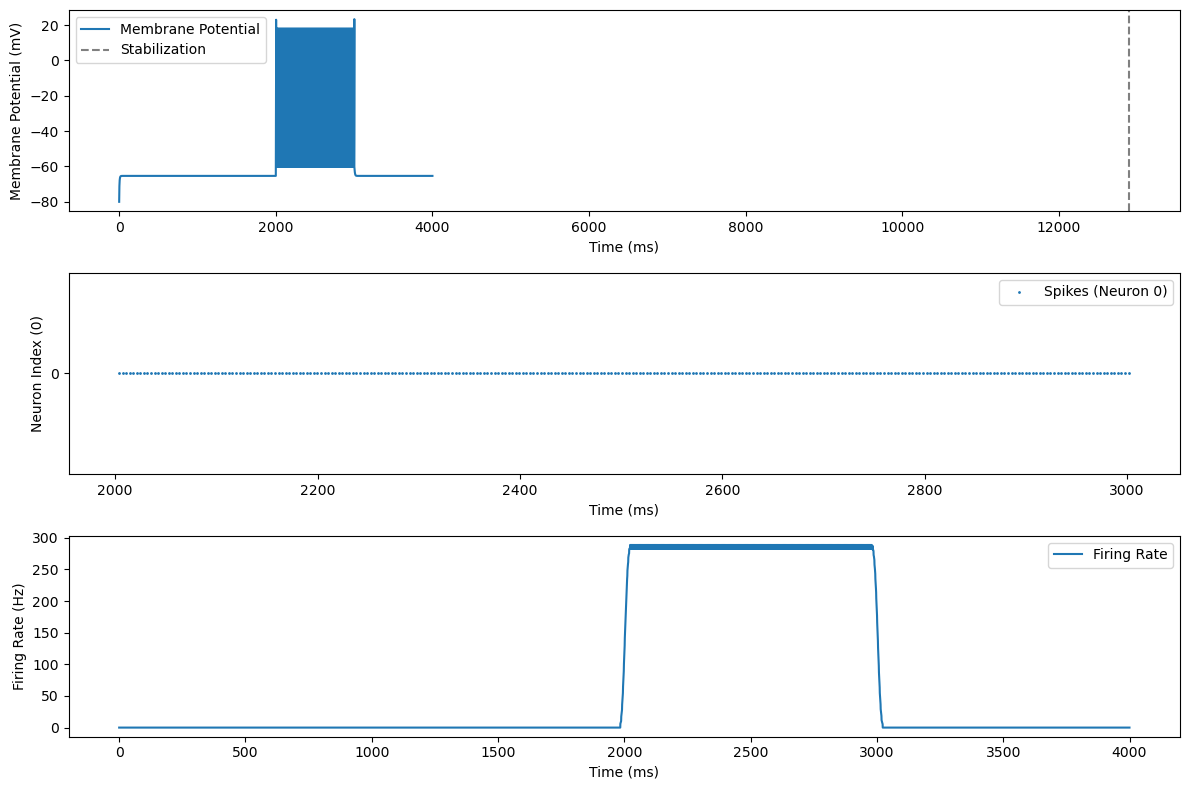

In [14]:
if __name__ == '__main__':
    main()